# **Speech Rate and Text Analysis Demo for a Patient Voice Story**

# **Part I** Using WHISPER for Speech Recognition

*The story **(1145pv768r3.mp3 - Taking time out)** chosen for this demonstration was selected by randomly sampling several stories and then picking one with relatively stable speech recognition results as a temporary analysis case.*

In [1]:
import whisper
import pickle
import time
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment

In [2]:
model = whisper.load_model("base")
demo_file = "1145pv768r3.mp3"

In [3]:
# Perform transcription analysis and measure execution time
time_begin = time.time()
result = model.transcribe(demo_file, language="en")
time_end = time.time()
time_length = time_end - time_begin
print(f"Total Time: {time_length:.2f} s")

C:\Users\74059\anaconda3\envs\GeoMusicLearn_5\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Total Time: 19.88 s


*Approximately 2.5 minutes of audio took less than 30 seconds to process using the "base" quality model, which seems acceptable for now.*

In [4]:
def output_result(result):
    for segment in result['segments']:
        text = segment['text']
        start = segment['start']
        end = segment['end']
        duration = end - start
        print(f"{start:.2f} - {end:.2f} ({duration:.2f} s): {text}")

In [5]:
output_result(result)

0.00 - 18.96 (18.96 s):  I was shouting at the kids again. It kept happening. I felt I was losing control. I realized
18.96 - 25.84 (6.88 s):  this was how stress felt, heart racing, sweating, muscles tense, emotions on overdrive.
25.84 - 33.28 (7.44 s):  No time to pause. I felt trapped. Too much medicine. Not enough time for our patients or ourselves.
35.12 - 41.60 (6.48 s):  Too many healthcare staff leaving. Some even seeing no way out. Taking their own lives.
42.56 - 48.48 (5.92 s):  Changes at work. But I was changing too. I was peddling too fast just to keep still.
49.52 - 54.48 (4.96 s):  We were working in silos. My family bore the burden as much as me.
56.80 - 62.56 (5.76 s):  But I talked. I knew I was not alone. I could make a difference. I could change things
63.28 - 69.36 (6.08 s):  and learn from others. I was helping medical and pharmacy students learn safe prescribing,
70.24 - 76.08 (5.84 s):  working together around a shared goal. Could teamwork, collaborative working

*The above is a summary of the speech recognition results based on each segment’s timing and duration.*

In [6]:
# Save as a pickle file
with open("whisper_result.pkl", "wb") as f:
    pickle.dump(result, f)

# **IMPORTANT WARNING!!!**: The code MUST be restart after **Part I** before running **Part II**.

*The reason is that the audio recognition library **Whisper** conflicts with the plotting library **Matplotlib**. Running them together can cause Jupyter Notebook to crash and restart.*

# **Part II** Analysis of Speech Rate and Script

## 2.1 Preparation and Basic Analyse

*Clean the speech recognition results obtained in Part I, and preliminarily calculate speech rate and other metrics based on the automatically recognized segments. The main calculation method is to compute, for each segment, the number of words divided by the duration.*

In [1]:
import string
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Load Whisper transcription result from pickle file
with open("whisper_result.pkl", "rb") as f:
    result = pickle.load(f)

In [3]:
# Create a translation table to remove punctuation
translator = str.maketrans('', '', string.punctuation)

# For each segment in result, convert text to lowercase, remove punctuation, trim spaces, and split into words
raw_word_list = [s['text'].lower().translate(translator).strip().split() for s in result['segments']]

# Join the cleaned word lists back into strings for each segment
clean_text_list = [" ".join(words) for words in raw_word_list]

# Combine all segments into one continuous cleaned text string
origin_text = " ".join(clean_text_list)

In [4]:
# Calculate the number of words in each segment
word_counts = np.array([len(words) for words in raw_word_list])

# Calculate duration of each segment (end time - start time)
durations = np.array([seg['end'] - seg['start'] for seg in result['segments']])

# Extract start and end times of segments
segment_starts = np.array([seg['start'] for seg in result['segments']])
segment_ends = np.array([seg['end'] for seg in result['segments']])

# Calculate speech rate for each segment (words per second)
segment_rates = durations/ word_counts

# Calculate cumulative word counts up to each segment
accumulate_word_counts = [sum(word_counts[:i+1]) for i in range(len(word_counts))]

In [5]:
# Calculate approximate occurrence time for each word within its segment
word_occurrence_time = []
for i, word_l in enumerate(raw_word_list):
    rate = segment_rates[i]
    start = segment_starts[i]
    word_occurrence_time.extend([start + rate*(j+1) for j in range(len(word_l))])

In [6]:
# Flatten the list of word lists into a single list of words
flat_word_list = []
for word_list in raw_word_list:
    flat_word_list.extend(word_list)

## 2.2 To assess speech recognition accuracy, a Term Frequency-Inverse Document Frequency (TF-IDF) based text similarity check was used.

*I chose to vectorize the original script and the speech recognition results using a TF-IDF based method, then calculate the cosine similarity as the criterion for text similarity. This approach is preferred because it is more sensitive compared to vectorization methods based solely on word frequency.*

In [7]:
# Read script text of "1145pv768r3.mp3" from text file
with open("script_1145.txt", "r", encoding = 'utf-8') as script_file:
    script = script_file.read()

In [8]:
print(script)

I was shouting at the kids again. It kept happening. I felt I was losing control. I realise this was how stress felt. Heart racing. Sweating. Muscles tense. Emotions on overdrive. No time to pause. I felt trapped. Too much medicine. Not enough time for our patients  - or ourselves.
Too many healthcare staff leaving.  Some even seeing no way out. Taking their own lives. Changes at work – but I was changing too. I was pedalling too fast just to keep still. We were working in silos. My family bore the burden as much as me.

But I talked. I knew I was not alone. I could make a difference. I could change things.
 And learn from others. I was helping medical and pharmacy students learn safe prescribing
Working together around a shared goal. Could teamwork, collaborative working help?  Could we use these principles in the wider healthcare team? Fostering well-being, working beyond and across professional boundaries. Tensions arose … and settled.

I began working with the team to make our live

*On the above is the original script draft of the "1145pv768r3.mp3"*

In [9]:
# Compute the pairwise cosine similarity matrix for a list of text documents using TF-IDF vectors
def quick_similarity_check(corpus):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(corpus)
    arr = tfidf_matrix.toarray()
    norm = np.linalg.norm(arr, axis=1, keepdims=True)
    norm_arr = arr / norm

    similarity_matrix = np.dot(norm_arr, norm_arr.T)
    return similarity_matrix

In [10]:
# Cleaning the raw script text by lowercasing, removing punctuation, trimming spaces, and normalizing whitespace
script_text = " ".join(script.lower().translate(translator).strip().split())

In [11]:
# Compute and print the cosine similarity
similarity = quick_similarity_check([origin_text, script_text])[0][1]
print(f"Similarity: {similarity:.1%}")

Similarity: 90.6%


*At this point, the text similarity between the speech recognition result and the script is about 90.6%, which I consider acceptable for use.*

## 2.3 TF-IDF Analysis on the Full Script and Each Segment

*Before performing TF-IDF analysis, all relevant texts must be preprocessed and cleaned. After the analysis, the results should be linked with the speech recognition timing and speech rate calculations.*

In [12]:
# Normalize a NumPy array to the [0, 1] range using min-max scaling.
def normalize_arr(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    return (arr - arr_min) / (arr_max - arr_min)

In [13]:
# Initialize the vectorizer (optionally filter out English stop words)
vectorizer = TfidfVectorizer(stop_words='english')

# Fit the vectorizer and transform the original text plus cleaned text list into TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform([origin_text] + clean_text_list)

# Retrieve the feature names (vocabulary terms)
feature_names = vectorizer.get_feature_names_out()

In [14]:
# Convert the sparse TF-IDF matrix to a DataFrame
df_tfidf = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out()
)

In [15]:
# Convert the first row of the TF-IDF DataFrame to a dictionary
tfidf_dict = df_tfidf.iloc[0].to_dict()

# Find the second highest unique TF-IDF value to use as a threshold
top = sorted(set(tfidf_dict.values()))[-2]

In [16]:
df_tfidf.head()

,achieve,approaches,asking,attending,began,better,bore,boundaries,breathe,burden,...,things,time,trapped,trying,use,way,wellbeing,wider,work,working
0,0.080305,0.080305,0.145169,0.080305,0.080305,0.080305,0.080305,0.080305,0.080305,0.080305,...,0.080305,0.217754,0.080305,0.080305,0.145169,0.080305,0.080305,0.080305,0.080305,0.308518
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.648411,0.358689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.388253,0.000000,0.000000,0.000000,0.000000


In [17]:
# Create a DataFrame with words and their corresponding occurrence times
df_words = pd.DataFrame({
    'Word': flat_word_list,
    'Occur_Time': word_occurrence_time
})

# Assign segment numbers and speech rates to each word based on segment info
df_words['Segment'] = np.repeat(np.array(range(len(word_counts))) + 1 , word_counts)
df_words['Rate'] = np.repeat(segment_rates , word_counts)

# Map overall TF-IDF values to words from the TF-IDF dictionary
df_words['tfidf_all'] = df_words['Word'].map(tfidf_dict)

# For each word, get the TF-IDF value specific to its segment from the TF-IDF DataFrame; assign 0 if missing
df_words['tfidf_seg'] = df_words.apply(lambda row: df_tfidf.at[row['Segment'], row['Word']] 
                           if row['Word'] in df_tfidf.columns and row['Segment'] in df_tfidf.index 
                           else 0, axis=1)

# Fill any missing values with 0
df_words = df_words.fillna(0)

In [18]:
df_words[df_words['Segment'] == 1]

,Word,Occur_Time,Segment,Rate,tfidf_all,tfidf_seg
0,i,1.053333,1,1.053333,0.000000,0.000000
1,was,2.106667,1,1.053333,0.000000,0.000000
2,shouting,3.160000,1,1.053333,0.080305,0.360662
3,at,4.213333,1,1.053333,0.000000,0.000000
4,the,5.266667,1,1.053333,0.000000,0.000000
5,kids,6.320000,1,1.053333,0.080305,0.360662
6,again,7.373333,1,1.053333,0.000000,0.000000
7,it,8.426667,1,1.053333,0.000000,0.000000
8,kept,9.480000,1,1.053333,0.080305,0.360662
9,happening,10.533333,1,1.053333,0.080305,0.360662


*Here, Segment 1 is selected as a demonstration example for TF-IDF. After calculation, the words  **"shouting", "kids", "kept", "happening", "felt", "losing", "control" and "realized"**  have higher scores both in the full text (tfidf_all) and the segment (tfidf_seg), indicating that these words may carry greater importance and information in the text. Additionally, I have linked these words with their occurrence order, timing, and speech rate to prepare for possible deeper analysis later.*

## 2.4 Visualizing the Current Results

2.4.1 **speech rate** : *The following is a plot of speech rate, analyzed based on the word count, duration, and start-end times of each recognized segment.*

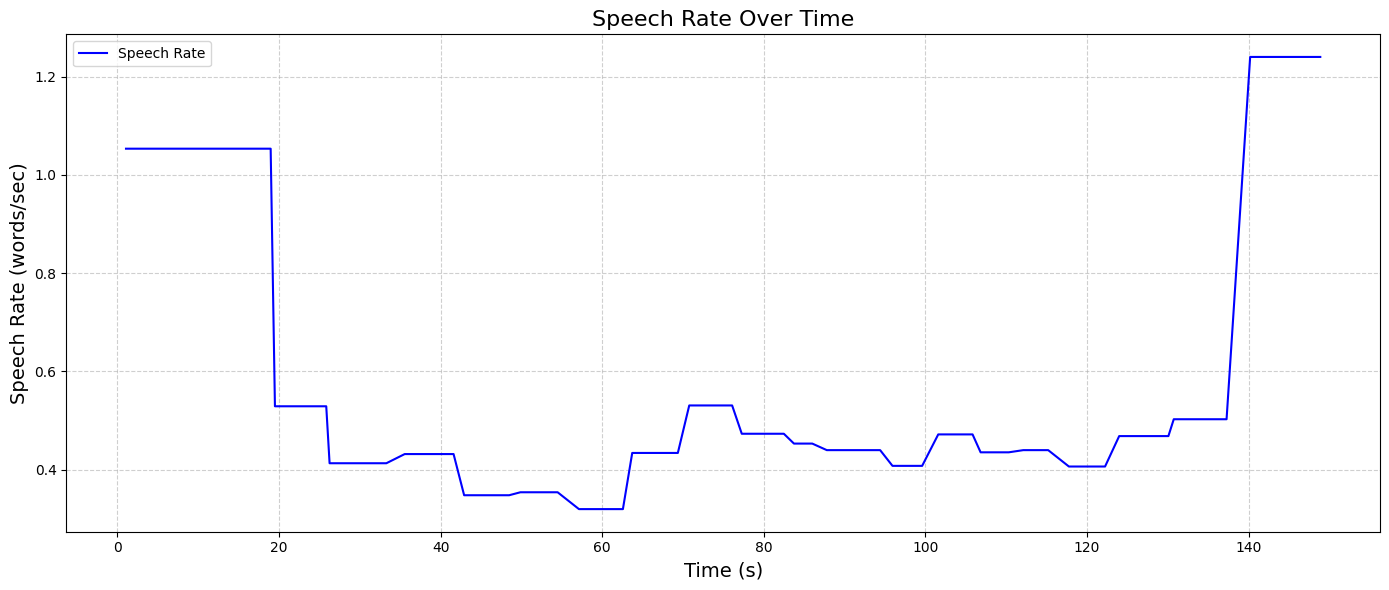

In [19]:
df = df_words

x = df['Occur_Time']
y = df['Rate']

# Set figure size
plt.figure(figsize=(14, 6))

# Plot line chart of speech rate over time
plt.plot(x, y, linestyle='-', color='blue', label='Speech Rate')

# Add title and axis labels with increased font size
plt.title('Speech Rate Over Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Speech Rate (words/sec)', fontsize=14)

# Display the plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

2.4.2 **Cumulative Word Count** : *The following is a plot of cumulative word count, showing how the number of words increases over time.*

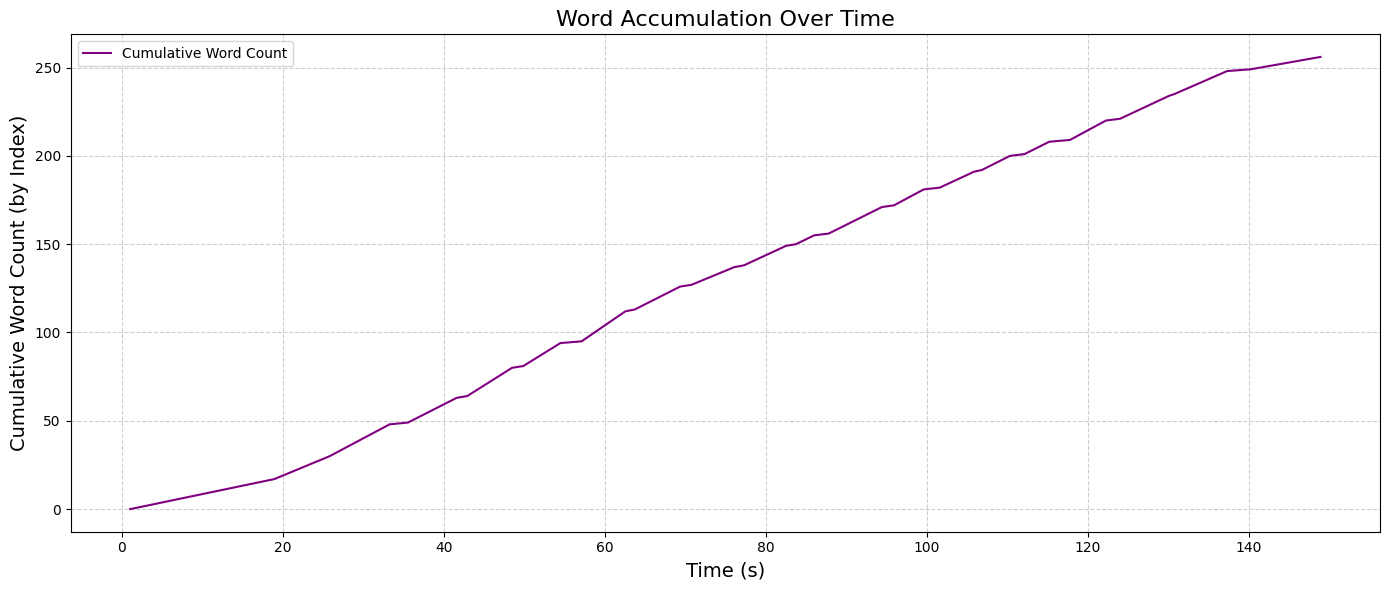

In [20]:
df = df_words

x = df['Occur_Time']
y = df.index

# Set figure size
plt.figure(figsize=(14, 6))

# Plot line chart showing cumulative word count over time
plt.plot(x, y, linestyle='-', color='purple', label='Cumulative Word Count')

# Add title and axis labels with increased font size
plt.title('Word Accumulation Over Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Cumulative Word Count (by Index)', fontsize=14)

# Display the plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

2.4.3 **Full-Text TF-IDF** : *The following plot shows the relationship between the full-text TF-IDF scores and time, reflecting the scores of different words and their occurrence time positions.*

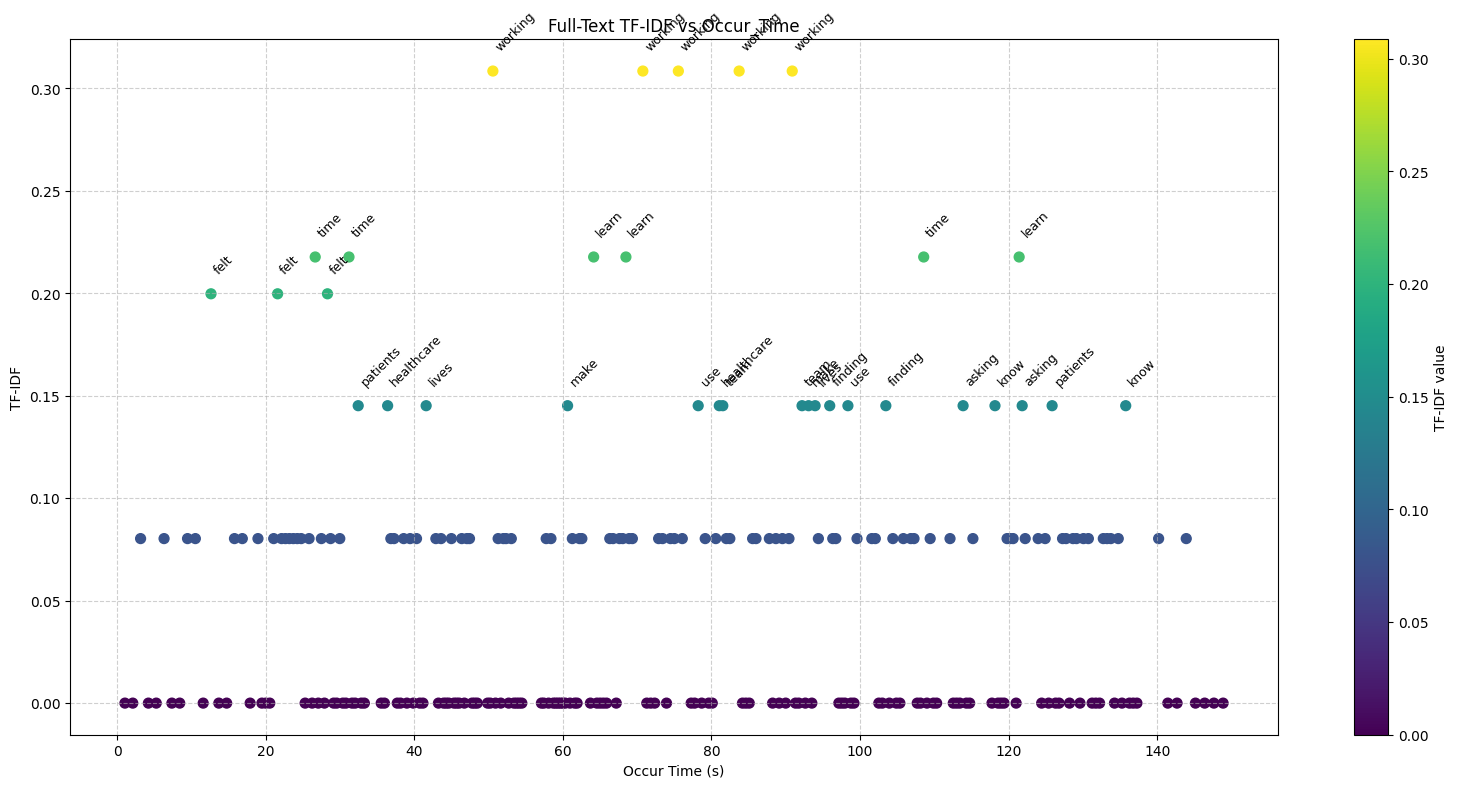

In [21]:
#
threshold = 0.1
df = df_words

x = df['Occur_Time']
y = df['tfidf_all']

# Set figure size
plt.figure(figsize=(16, 8))

# Scatter plot: use y values for color mapping, cmap defines color scheme
scatter = plt.scatter(x, y, c=y, cmap='viridis', s=50)

# Add colorbar to indicate TF-IDF values
plt.colorbar(scatter, label='TF-IDF value')

# Annotate points where TF-IDF exceeds the threshold
for i, row in df.iterrows():
    if row['tfidf_all'] > threshold:
        plt.text(
            row['Occur_Time'] + 0.05,
            row['tfidf_all'] + 0.01,
            row['Word'],
            fontsize=9,
            rotation=45
        )

# Set plot title and axis labels
plt.title('Full-Text TF-IDF vs Occur_Time')
plt.xlabel('Occur Time (s)')
plt.ylabel('TF-IDF')

# Display the plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

2.4.4 **Segment TF-IDF** : *The following shows the relationship between TF-IDF scores and time for each segment, reflecting the scores of different words within each segment and their occurrence time positions.*

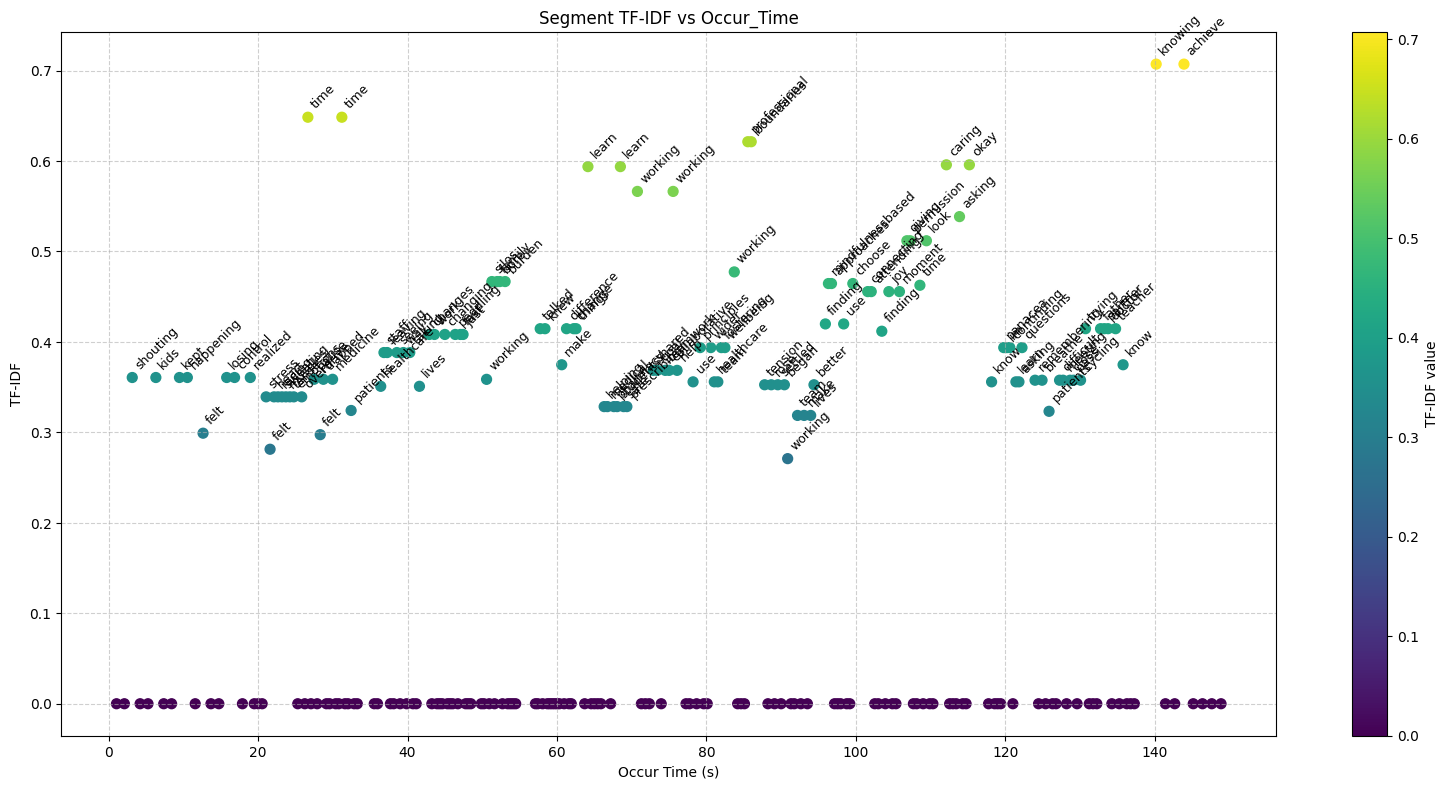

In [22]:
#
threshold = top
df = df_words

x = df['Occur_Time']
y = df['tfidf_seg']

# Set figure size
plt.figure(figsize=(16, 8))

# Scatter plot: use y values for color mapping, cmap defines color scheme
scatter = plt.scatter(x, y, c=y, cmap='viridis', s=50)

# Add colorbar to indicate TF-IDF values
plt.colorbar(scatter, label='TF-IDF value')

# Annotate points where TF-IDF exceeds the threshold
for i, row in df.iterrows():
    if row['tfidf_seg'] > threshold:
        plt.text(
            row['Occur_Time'] + 0.05,
            row['tfidf_seg'] + 0.01,
            row['Word'],
            fontsize=9,
            rotation=45
        )

# Set plot title and axis labels
plt.title('Segment TF-IDF vs Occur_Time')
plt.xlabel('Occur Time (s)')
plt.ylabel('TF-IDF')

# Display the plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

2.4.5 **Word Cloud** : *The following is a word cloud generated using the TF-IDF scores from the full text as weights.*

In [23]:
#
from wordcloud import WordCloud

# Create a dictionary mapping words to their TF-IDF segment scores
word_freq = dict(zip(df['Word'], df['tfidf_seg']))

# Select a colormap
cmap = plt.get_cmap('viridis')

# Normalize TF-IDF values to the [0, 1] range
tfidf_values = np.array(list(word_freq.values()))
min_tfidf, max_tfidf = tfidf_values.min(), tfidf_values.max()

def normalize(val):
    if max_tfidf == min_tfidf:
        return 0.5
    return (val - min_tfidf) / (max_tfidf - min_tfidf)

# Color function for the word cloud; receives word and frequency as inputs
def color_func(word, **kwargs):
    normalized_val = normalize(word_freq.get(word, 0))
    r, g, b, _ = cmap(normalized_val)
    return f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"

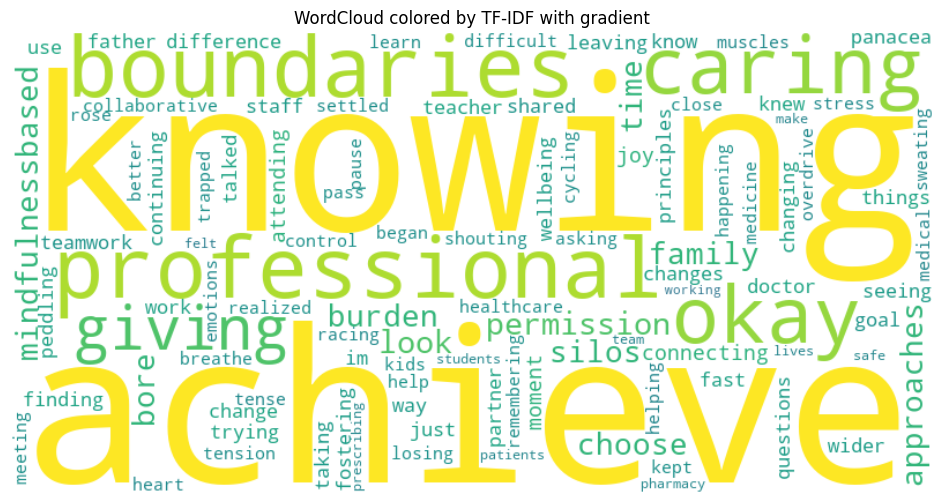

In [24]:
#
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wc.recolor(color_func=color_func), interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud colored by TF-IDF with gradient')
plt.show()

2.4.6 **Combined Normalized Analysis Results** : *The following is a combined plot of several main analysis results after normalization.*

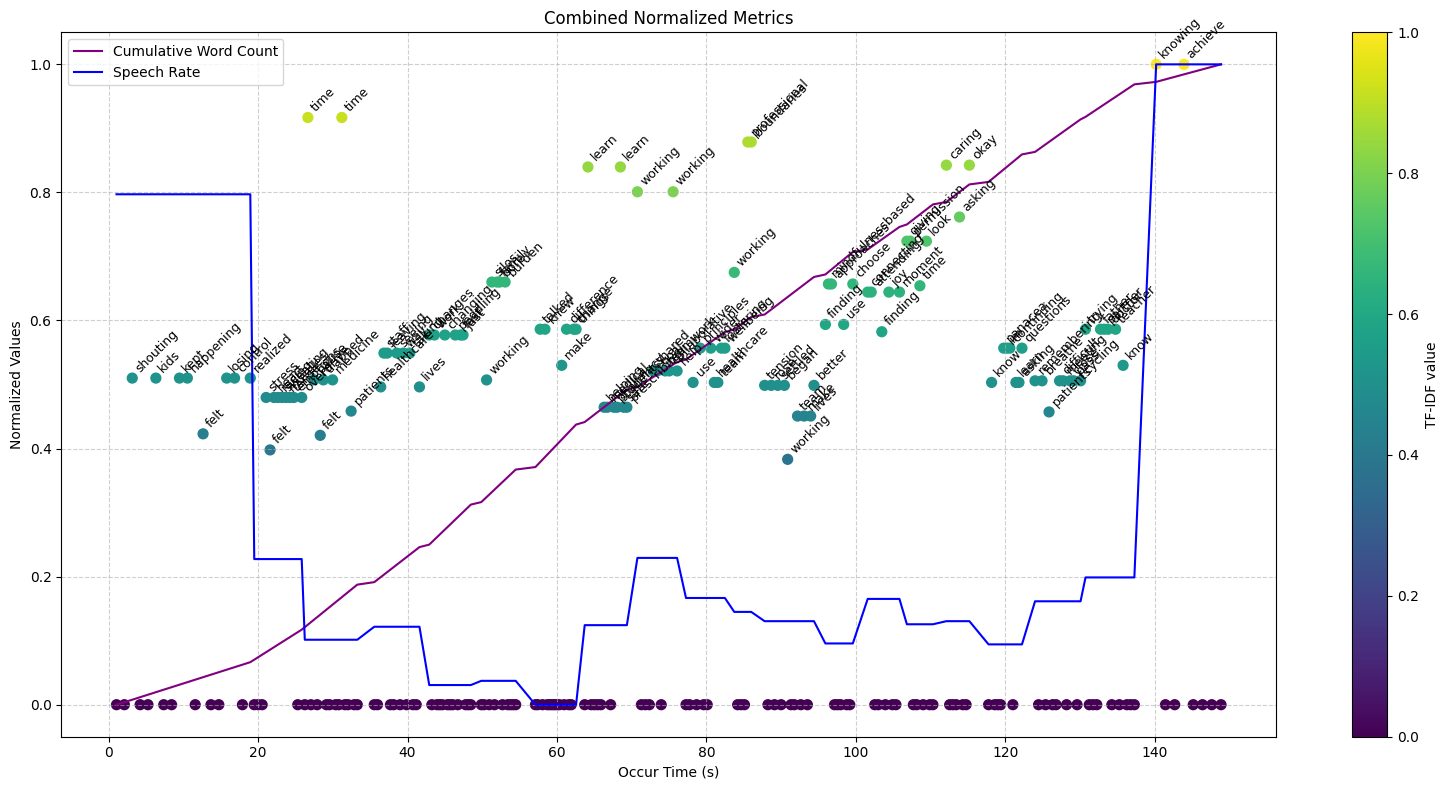

In [25]:
#
threshold = top
df = df_words

# Extract occurrence time and normalized TF-IDF segment scores
x = df['Occur_Time']
y = normalize_arr(df['tfidf_seg'])

# Set figure size
plt.figure(figsize=(16, 8))

# Use y values for color mapping; pass y to c, set cmap for color style
scatter = plt.scatter(x, y, c=y, cmap='viridis', s=50)
plt.colorbar(scatter, label='TF-IDF value')

for i, row in df.iterrows():
    if row['tfidf_seg'] > threshold:
        plt.text(
            row['Occur_Time'] + 0.05, y[i] + 0.01,
            row['Word'], fontsize=9, rotation=45
        )
# Plot cumulative word count and speech rate, normalized for comparison
plt.plot(x, normalize_arr(df.index), linestyle='-', color='purple', label='Cumulative Word Count')
plt.plot(x, normalize_arr(df['Rate']), linestyle='-', color='blue', label='Speech Rate')

# Set title and axis labels
plt.title('Combined Normalized Metrics')
plt.xlabel('Occur Time (s)')
plt.ylabel('Normalized Values')

# Adjust layout and display plot
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()